# S&P 500 stock data


data from https://www.kaggle.com/camnugent/sandp500

***Задача***: изучить биржевые показатели 500 крупнейших компаний США, определить, насколько они различны, проавализировать рынок в целом, взяв средние значения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
stock = pd.read_csv('data/all_stocks_5yr.csv', sep =',')
stock['date'] = pd.to_datetime(stock.date,format='%Y-%m-%d') 
stock.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


**S&P 500 ** is an American stock market index based on the market capitalizations of 500 large companies having common stock listed on the NYSE or NASDAQ. The S&P 500 index components and their weightings are determined by S&P Dow Jones Indices.

**Volume** is the number of shares or contracts traded in a security or an entire market during a given period of time. For every buyer, there is a seller, and each transaction contributes to the count of total volume. That is, when buyers and sellers agree to make a transaction at a certain price, it is considered one transaction.

**A stock index** or stock market index is a measurement of a section of the stock market. It is computed from the prices of selected stocks (typically a weighted average). It is a tool used by investors and financial managers to describe the market, and to compare the return on specific investments.

**open** - the index at the opening of an exchange

**high** - the higest index

**low** - the lowest index

**close** - the index at the closing of an exchange

### Предобработка датафрема

Датафрейм состоит из информации о многих компаниях. Разобьем его по названием компаний на словарь датафремов

In [3]:
# 500 companies
print(stock['Name'].unique()[0:5])
print("компаний в сыром датасете: ", len(stock['Name'].unique()))
stock['Name'].value_counts()[::50]

['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC']
компаний в сыром датасете:  505


QCOM    1259
PRGO    1259
FB      1259
DHI     1259
WBA     1259
LLL     1259
NTRS    1259
CMS     1259
PPL     1259
ETFC    1259
DXC      215
Name: Name, dtype: int64

видим, что не по всем компаниям есть полная информация (1259 строк). Удалим эти объекты из датасета

In [4]:
normal_data_length = 1259;

stock.index  = stock.date
comp_data = dict()

# разбиваем датафрейм
for company_name in stock['Name'].unique():
    data = stock.loc[stock['Name'] == company_name]
    if data.shape[0] != normal_data_length:
        continue
    comp_data[company_name] = data
    comp_data[company_name].index  = comp_data[company_name].date
    
print("компаний в обработанном датасете: ", len(comp_data))    

компаний в обработанном датасете:  470


### Визулизируем объём торгов


Возьмем 9 случайновыбранных компаний

    

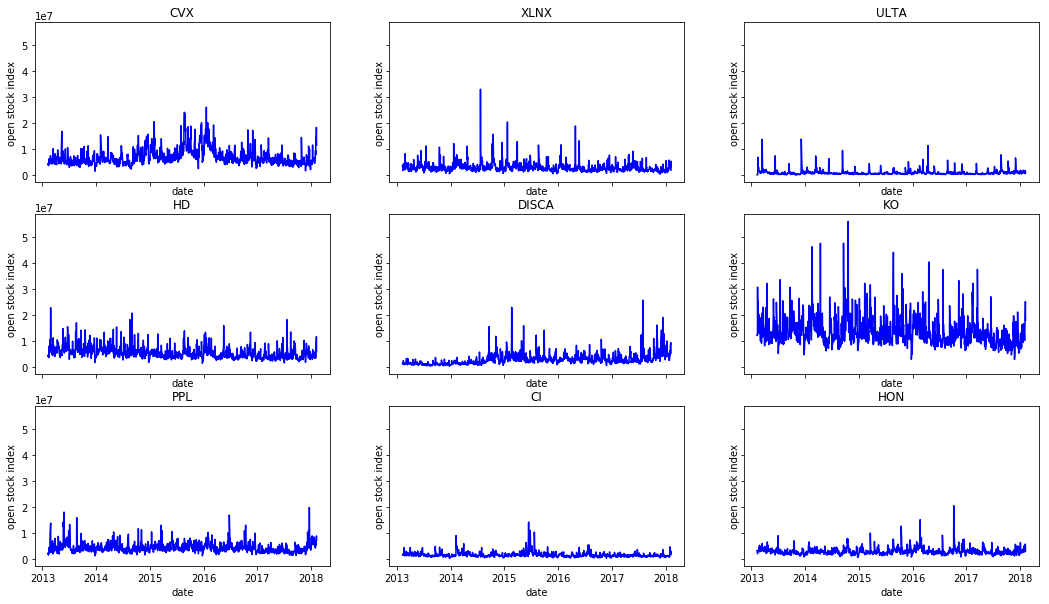

In [56]:
# генерит случайные компании
def rand_keys(some_dict, length):
    if length>len(some_dict):
        return null
    return np.random.permutation([*some_dict])[0:length]   

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(18)

rand_comp = rand_keys(comp_data, 3*3)

for i in range(3):
    for j in range(3):
        name = rand_comp[i*3+j]
        axes[i, j].plot(comp_data[name]['date'], comp_data[name]['volume'], 'b')
        axes[i, j].set_title(name)
        axes[i, j].set_xlabel('date')
        axes[i, j].set_ylabel('open stock index')

**Вывод**: фондовые индексы разных компаний не очень похожи, но математически точно мы все еще не знаем - насколько

### Проверка статистических гипотез

**Задача**: выяснить, являются ли различия между топ-500 компаний статистически значемыми.

1. Проверим следующие гипотезу H_0 - выборки взяты из одной совокупности


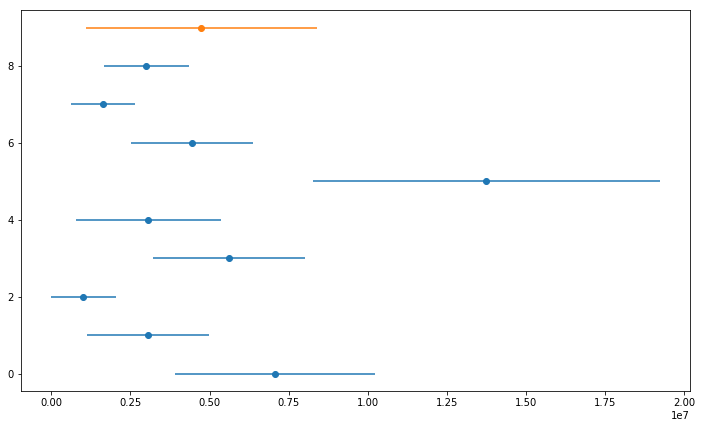

In [57]:
rand_group = list()
[rand_group.append(comp_data[i]['volume']) for i in rand_comp]

x = np.mean(rand_group,axis = 1)
y = np.arange(len(rand_group))
e = np.std(rand_group,axis = 1)

plt.errorbar(x, y, xerr = e, linestyle='None', marker='o')
plt.errorbar(np.mean(x), len(y) ,xerr =  np.std(x), linestyle='None', marker='o')
plt.show()

In [58]:
F, p = stats.f_oneway(*[i for i in rand_group])
print("F =", F)
print("p =", p)

F = 2717.015018021867
p = 0.0


p - вероятность ошибочно отвергнуть верную нулевую гипотезу, то есть найти различия там, где их нет.
p < 0.05 => выборки взяты из разных распределений => Объем торгов разных компаний существенно отличается

2. Проверим следующую гипотезу: самые торгуемые 20% компаний из датасата составляют 80% объёма торгов

In [84]:
# суммирует последние 10 значений
def volume_sum(some_frame):
    return np.sum(some_frame[-10:])

volume_array = [volume_sum(comp_data[name]['volume']) for name in [*comp_data]]
gener_value = np.sum(volume_array)
print("общий объем торгов за последние 10 дней =", gener_value)
top = np.argsort(volume_array)
top_20_value = 0
for i in range(len(volume_array)//5):
    top_20_value += volume_array[top[i]]
    
print("объем торгов за последние 10 дней топ 20% компаний =", top_20_value)

if top_20_value == gener_value * 0.8:
    print('\n', "гипотеза подтверждена")
else:
    print('\n', "гипотеза не подтверждена")

общий объем торгов за последние 10 дней = 26142772700
объем торгов за последние 10 дней топ 20% компаний = 935384789

 гипотеза не подтверждена



## Рассмотрим средний фондовый индекс топ-американских компаний


In [108]:
# создаем датафрейм из средних значений фондового индекса на момент открытия биржи
mean_index = list()
date = list(comp_data['AAL']['date'])
mean_open_inx = np.sum([comp_data[name]['open'] for name in comp_data], axis = 0) / len(comp_data)
mean_inx_data = pd.DataFrame({'date': pd.Series(date), 'open_index': pd.Series(mean_open_inx)})
# mean_inx_data['open_index'].fillna((mean_inx_data['open_index'].mean()), inplace=True)
mean_inx_data = mean_inx_data.dropna(axis=0)
# mean_inx_data.isnull().sum().sum()

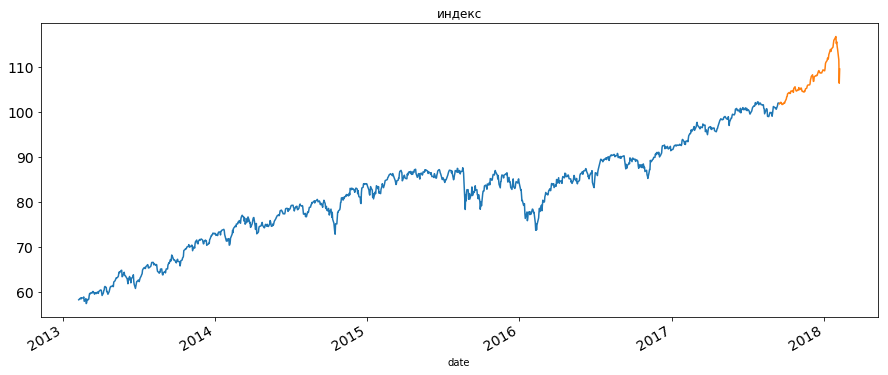

In [19]:
mean_inx_data.index  = mean_inx_data.date
train = mean_inx_data[:-100]
test = mean_inx_data[-100:]
train.open_index.plot( figsize=(15,6),title= 'индекс', fontsize=14)
test.open_index.plot( figsize=(15,6),title= 'индекс', fontsize=14)

### Визуализация компонентов временного ряда

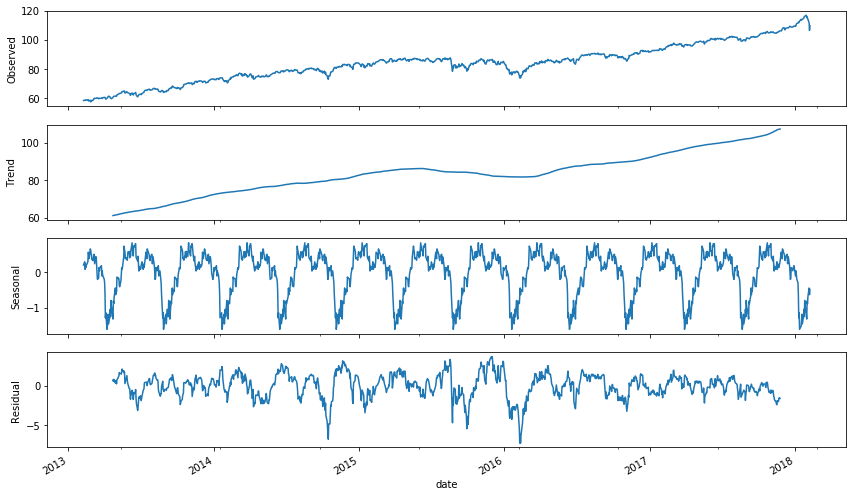

In [10]:
plt.rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(mean_inx_data.open_index, freq=100).plot()
plt.show()

**выводы**:

американский рынок плавно растет с 2013 по 2018 года (промежуток, охваченный датафреймом)

раз в 4 месяца случается что-то странное и необъяснимое, из-за чего фондовый индекс проседает

### предскажем значения временного ряда

In [29]:
# выясняем, стационарен ли ряд (хотя по графикам выше видно, что нет. не вдруг?)

test_try_st = sm.tsa.adfuller(mean_inx_data.open_index)
print ('adf: ', test_try_st[0] )
print ('p-value: ', test_try_st[1])
print('Critical values: ', test_try_st[4])
if test_try_st[0]> test_try_st[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -13.02943687885139
p-value:  2.3618520008075577e-24
Critical values:  {'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}
единичных корней нет, ряд стационарен


In [28]:
# избавляемся от нестационарности

mean_inx_data = mean_inx_data.diff(periods=1).dropna()

test_try_st = sm.tsa.adfuller(mean_inx_data.open_index)
print ('adf: ', test_try_st[0] )
print ('p-value: ', test_try_st[1])
print('Critical values: ', test_try_st[4])
if test_try_st[0]> test_try_st[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')
       

adf:  -13.02943687885139
p-value:  2.3618520008075577e-24
Critical values:  {'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}
единичных корней нет, ряд стационарен



ура! избавились от нестационарности!


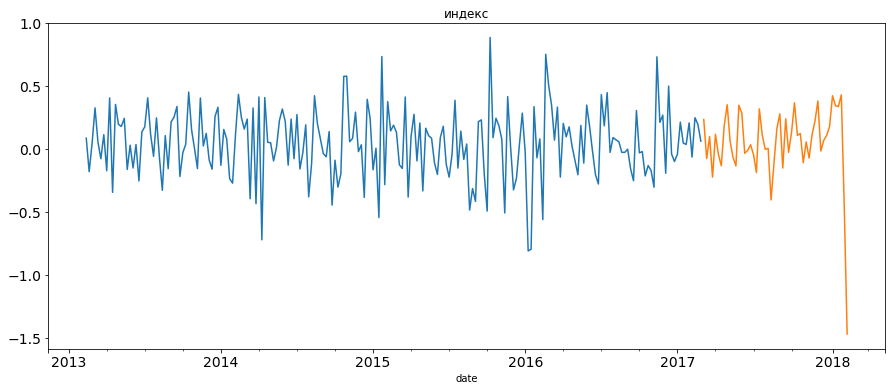

In [35]:
# убираем выбросы и рисуем новый график временного ряда
mean_inx_data = mean_inx_data.resample('W').mean()
train = mean_inx_data[:-50]
test = mean_inx_data[-50:]
train.open_index.plot( figsize=(15,6),title= 'индекс', fontsize=14)
test.open_index.plot( figsize=(15,6),title= 'индекс', fontsize=14)

In [103]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing

y_hat = test.copy()

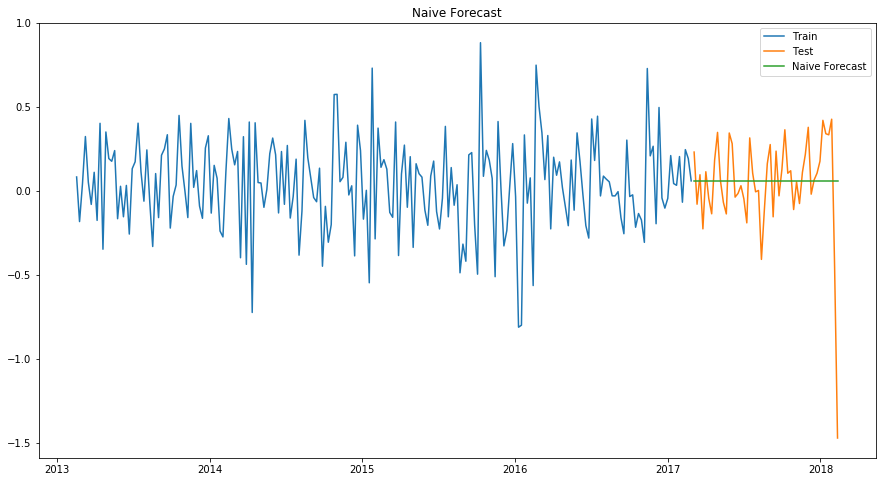

In [104]:
y_hat['naive'] = train.open_index[-1]

plt.figure(figsize=(15,8))
plt.plot(train.index, train.open_index, label='Train')
plt.plot(test.open_index, label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [105]:
# Посчитаем, как мы ошиблись
sqrt(mean_squared_error(test.open_index, y_hat.naive))

0.29487131994464433

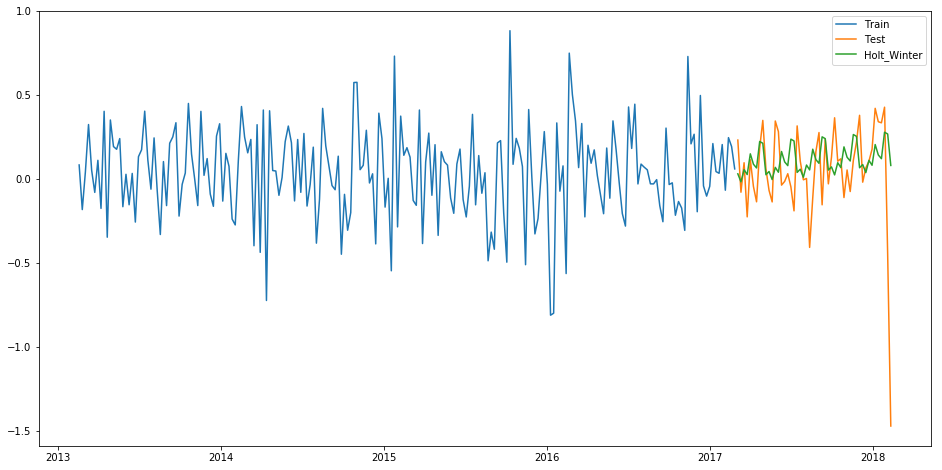

In [106]:
fit1 = ExponentialSmoothing(np.asarray(train.open_index) ,seasonal_periods=10 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train.open_index, label='Train')
plt.plot(test.open_index, label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [98]:
rms = sqrt(mean_squared_error(test.open_index, y_hat.Holt_Winter))
print(rms)

0.3073602063871487


## Вывод

Фондовый рынок в целом растет, примерно раз в 4 месяца общий фондовый индекс проседает.

При прогнозировании был реализован наивный прогноз и прогноз с использованием метода Холта-Уинтерса.
Оба прогноза хорошо описывают временной ряд за исключением резкого падения в самом конце исследуемого промежутка времени.
Объем торгов разнфх компаний значительно разнится, однако нельзя сказать, что самые крупные компании составляют значительную долю рынка